# Venkatesh Prasad Venkataramanan PID : A53318036

In [42]:
%matplotlib notebook

import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import torchvision as tv
from PIL import Image
import matplotlib.pyplot as plt
import nntools as nt

In [43]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## Question 1

In [44]:
dataset_root_dir = '/datasets/ee285f-public/bsds'

## Question 2

In [45]:
class NoisyBSDSDataset(td.Dataset):

    def __init__(self, root_dir, mode='train', image_size=(180, 180), sigma=30):
        super(NoisyBSDSDataset, self).__init__()
        self.mode = mode
        self.image_size = image_size
        self.sigma = sigma
        self.images_dir = os.path.join(root_dir, mode)
        self.files = os.listdir(self.images_dir)

    def __len__(self):
        return len(self.files)

    def __repr__(self):
        return "NoisyBSDSDataset(mode={}, image_size={}, sigma={})". \
            format(self.mode, self.image_size, self.sigma)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.files[idx])
        clean = Image.open(img_path).convert('RGB')
        i = np.random.randint(clean.size[0] - self.image_size[0])
        j = np.random.randint(clean.size[1] - self.image_size[1])
        #self.sigma = sigma
        clean = clean.crop([i, j, i+self.image_size[0], j+self.image_size[1]])
        transform = tv.transforms.Compose([
            tv.transforms.Resize(self.image_size),
            tv.transforms.ToTensor(),
            tv.transforms.Normalize((.5, .5, .5), (.5, .5, .5))
            
            ])
        clean = transform(clean)
        noisy = clean + 2 / 255 * self.sigma * torch.randn(clean.shape)
        return noisy, clean

## Question 3 

In [46]:
train_set = NoisyBSDSDataset(dataset_root_dir,mode = 'train')
test_set = NoisyBSDSDataset(dataset_root_dir,mode = 'test',image_size=(320,320))

In [47]:
x = test_set.__getitem__(12)

In [48]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

<IPython.core.display.Javascript object>


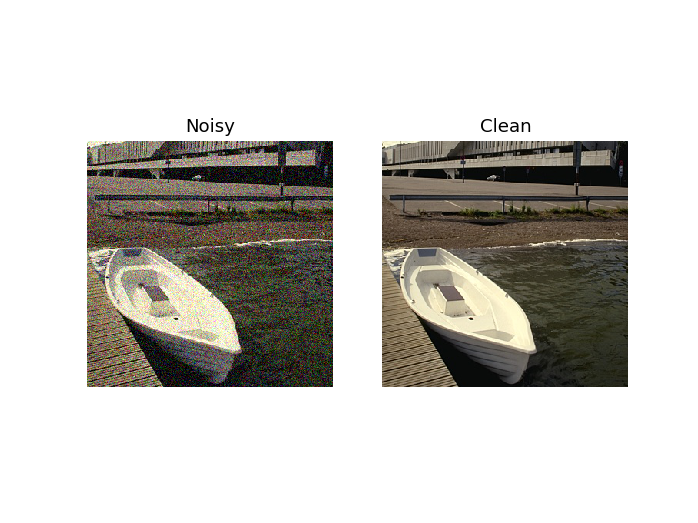

Text(0.5, 1.0, 'Clean')

In [49]:
fig, axes = plt.subplots(ncols=2)
myimshow(x[0], ax=axes[0])
axes[0].set_title('Noisy')
myimshow(x[1], ax=axes[1])
axes[1].set_title('Clean')

## Question 4

In [50]:
class NNRegressor(nt.NeuralNetwork):

    def __init__(self):
        super(NNRegressor, self).__init__()
        self.mse = nn.MSELoss()

    def criterion(self, y, d):
        return self.mse(y, d)

## Question 5

In [51]:
class DnCNN(NNRegressor):

    def __init__(self, D, C=64):
        super(DnCNN, self).__init__()
        self.D = D
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv2d(3, C, 3, padding=1))
        self.conv.extend([nn.Conv2d(C, C, 3, padding=1) for _ in range(D)])
        self.conv.append(nn.Conv2d(C, 3, 3, padding=1))                     
        self.bn = nn.ModuleList()
        for k in range(D):
            self.bn.append(nn.BatchNorm2d(C))

    def forward(self, x):
        D = self.D
        h = F.relu(self.conv[0](x))
        for i in range(D):
            h = F.relu(self.bn[i](self.conv[i+1](h)))# COMPLETE
        y = self.conv[D+1](h) + x
        return y

We are choosing one layer of zero-padding. The number of zero-padding is chosen as (Filter size - 1)/2 , hence it is 1.

## Question 6

In [52]:
class DenoisingStatsManager(nt.StatsManager):

    def __init__(self):
        super(DenoisingStatsManager, self).__init__()

    def init(self):
        super(DenoisingStatsManager, self).init()
        self.running_PSNR = 0

    def accumulate(self, loss, x, y, d):
        super(DenoisingStatsManager, self).accumulate(loss, x, y, d)    
        n = x.shape[0] * x.shape[1] * x.shape[2] * x.shape[3]
        self.running_PSNR += 10*torch.log10(4*n/(torch.norm(y-d)**2))

    def summarize(self):
        loss = super(DenoisingStatsManager, self).summarize()
        PSNR = self.running_PSNR / self.number_update
        return {'loss': loss, 'PSNR': PSNR}

## Question 7

In [53]:
dncnn = DnCNN(D = 6)
dncnn = dncnn.to(device)
lr = 1e-3
#val_set = NoisyBSDSDataset(dataset_root_dir,mode = 'val')
adam = torch.optim.Adam(dncnn.parameters(), lr=lr)
stats_manager = DenoisingStatsManager()
exp1 = nt.Experiment(dncnn, train_set, test_set, adam, stats_manager, 
               output_dir="denoising1",batch_size=4, perform_validation_during_training=True)

## Question 8

In [54]:
def plot(exp, fig, axes, noisy, visu_rate=2):
    if exp.epoch % visu_rate != 0:
        return
    with torch.no_grad():
        denoised = exp.net(noisy[np.newaxis].to(exp.net.device))[0]
    axes[0][0].clear()
    axes[0][1].clear()
    axes[1][0].clear()
    axes[1][1].clear()
    
    
    myimshow(noisy, ax=axes[0][0])
    axes[0][0].set_title('Noisy image')
    
    myimshow(denoised, ax=axes[0][1])
    axes[0][1].set_title('Denoised image')
    
    axes[1][0].plot([exp.history[k][0]['loss'] for k in range(exp.epoch)], label='training loss')
    axes[1][0].set_ylabel('Loss')
    axes[1][0].set_xlabel('Epoch')
    axes[1][0].legend()
    
    axes[1][1].plot([exp.history[k][0]['PSNR'] for k in range(exp.epoch)], label='training psnr')
    axes[1][1].set_ylabel('PSNR')
    axes[1][1].set_xlabel('Epoch')
    axes[1][1].legend()
    
    plt.tight_layout()
    fig.canvas.draw()
    

<IPython.core.display.Javascript object>


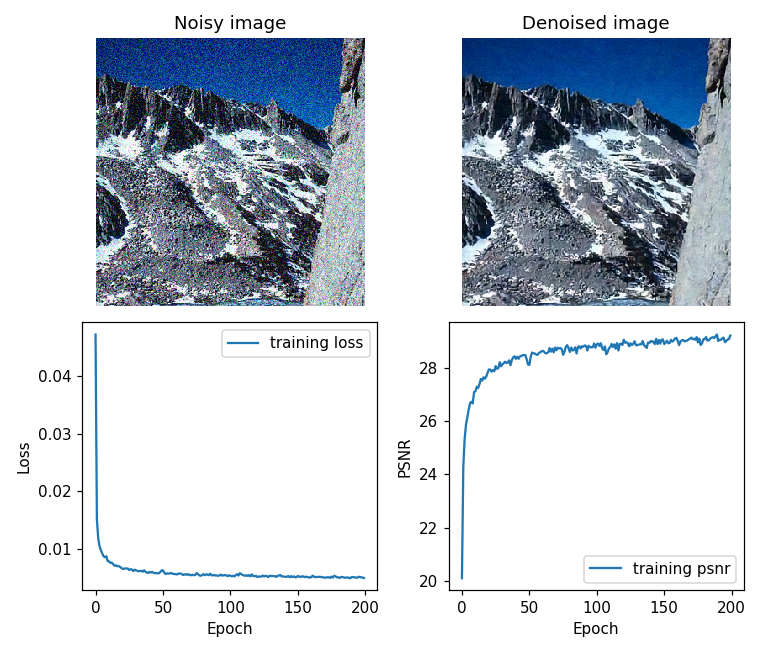

Start/Continue training from epoch 200
Finish training for 200 epochs


In [55]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(7,6))
exp1.run(num_epochs=200, plot=lambda exp: plot(exp, fig=fig, axes=axes,
                                                noisy=test_set[73][0]))

## Question 9

<IPython.core.display.Javascript object>


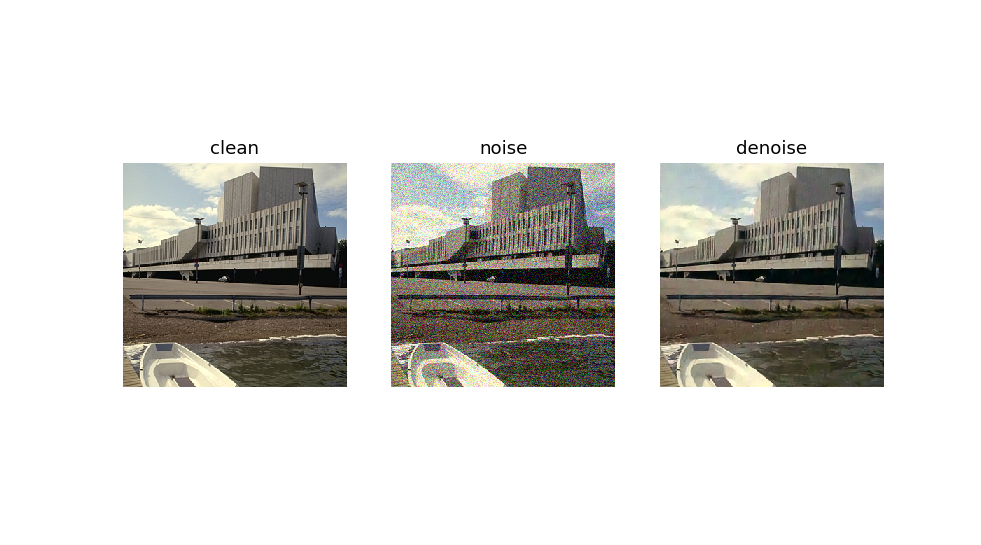

In [56]:
img = []
trained_network = exp1.net.to(device)
titles = ['clean', 'noise', 'denoise']

x, clean = test_set.__getitem__(12)
x = x.unsqueeze(0).to(device)
img.append(clean)
img.append(x[0])

trained_network.eval()
with torch.no_grad():
    y = trained_network.forward(x)
img.append(y[0])
    
fig, axes = plt.subplots(ncols=3, figsize=(9,5), sharex='all', sharey='all')
for i in range(len(img)):
    myimshow(img[i], ax=axes[i])
    axes[i].set_title(f'{titles[i]}')

The denoised image does look good, but we can see that some areas have lost information. PSNR isn't actually great

## Question 10

In [57]:
for name, param in trained_network.named_parameters():
    print(name, param.size(), param.requires_grad)

conv.0.weight torch.Size([64, 3, 3, 3]) True
conv.0.bias torch.Size([64]) True
conv.1.weight torch.Size([64, 64, 3, 3]) True
conv.1.bias torch.Size([64]) True
conv.2.weight torch.Size([64, 64, 3, 3]) True
conv.2.bias torch.Size([64]) True
conv.3.weight torch.Size([64, 64, 3, 3]) True
conv.3.bias torch.Size([64]) True
conv.4.weight torch.Size([64, 64, 3, 3]) True
conv.4.bias torch.Size([64]) True
conv.5.weight torch.Size([64, 64, 3, 3]) True
conv.5.bias torch.Size([64]) True
conv.6.weight torch.Size([64, 64, 3, 3]) True
conv.6.bias torch.Size([64]) True
conv.7.weight torch.Size([3, 64, 3, 3]) True
conv.7.bias torch.Size([3]) True
bn.0.weight torch.Size([64]) True
bn.0.bias torch.Size([64]) True
bn.1.weight torch.Size([64]) True
bn.1.bias torch.Size([64]) True
bn.2.weight torch.Size([64]) True
bn.2.bias torch.Size([64]) True
bn.3.weight torch.Size([64]) True
bn.3.bias torch.Size([64]) True
bn.4.weight torch.Size([64]) True
bn.4.bias torch.Size([64]) True
bn.5.weight torch.Size([64]) True

So number of parameters is given by 64x3x3x3(first layer) + 64x64x3x3xD(D layers) + 3x64x3x3(final layer).

Receptive field is given by formula 2^(k-l+1), where k is number of unpooling layers and l is number of pooling layers. \
So total receptive field is given by (1 + 2^(k-l+1) x (D + 2))^2(since for input field it will be 1). \
K = 0, l = 0, hence it is given by (1 + 2 x (D + 2))^2.

## Question 11

Since it has to be 33 x 33, (1 + 2 x (D + 2))^2 = 33 x 33, D =14.\
So number of parameters is 519552.
More the parameters, more the computation time.

## Question 12

In [58]:
class UDnCNN(NNRegressor):

    def __init__(self, D, C=64):
        super(UDnCNN, self).__init__()
        self.D = D
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv2d(3, C, 3, padding=1))
        self.conv.extend([nn.Conv2d(C, C, 3, padding=1) for _ in range(D)])
        self.conv.append(nn.Conv2d(C, 3, 3, padding=1))
        
        self.bn = nn.ModuleList()
        self.bn.extend([nn.BatchNorm2d(C, C) for _ in range(D)])
        

    def forward(self, x):
        D = self.D
        h = F.relu(self.conv[0](x))
        hbuff = []
        indexbuff = []
        shapebuff = []
        for i in range(D//2-1):
            shapebuff.append(h.shape)
            h, idx = F.max_pool2d(F.relu(self.bn[i](self.conv[i+1](h))), 
                                  kernel_size=(2,2), return_indices=True)
            hbuff.append(h)
            indexbuff.append(idx)
        for i in range(D//2-1, D//2+1):
            h = F.relu(self.bn[i](self.conv[i+1](h)))
        for i in range(D//2+1, D):
            j = i - (D//2 + 1) + 1
            h = F.max_unpool2d(F.relu(self.bn[i](self.conv[i+1]((h+h_buff[-j])/np.sqrt(2)))), 
                               idx_buff[-j], kernel_size=(2,2), output_size=shape_buff[-j])
        y = self.conv[D+1](h) + x
        return y

## Question 13

In [59]:
lr = 1e-3
udncnn = UDnCNN(6)
udncnn = UDnCNN(6).to(device)
adam = torch.optim.Adam(udncnn.parameters(), lr=lr)
stats_manager = DenoisingStatsManager()
exp2 = nt.Experiment(udncnn, train_set, test_set, adam, stats_manager, batch_size=4, 
               output_dir="denoising2", perform_validation_during_training=True)

<IPython.core.display.Javascript object>


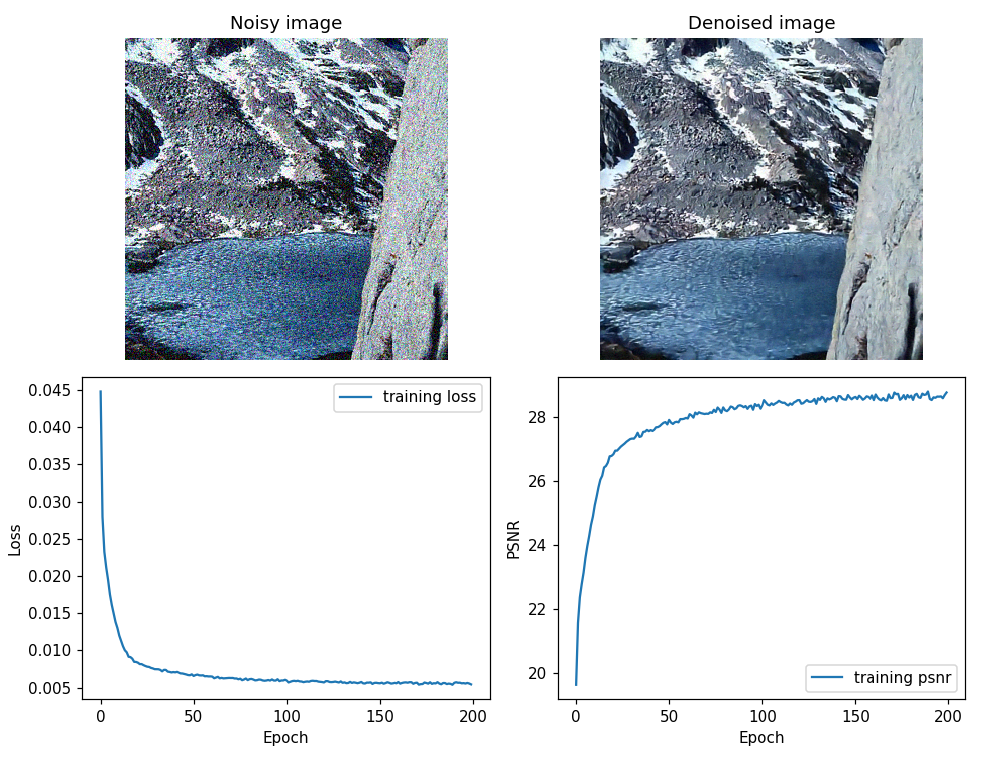

Start/Continue training from epoch 200
Finish training for 200 epochs


In [60]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(9, 7))
exp2.run(num_epochs=200, plot=lambda exp: plot(exp, fig=fig, axes=axes,
                                                noisy=test_set[73][0]))

## Question 14

In [61]:
for name, param in exp2.net.named_parameters():
    print(name, param.size(), param.requires_grad)

conv.0.weight torch.Size([64, 3, 3, 3]) True
conv.0.bias torch.Size([64]) True
conv.1.weight torch.Size([64, 64, 3, 3]) True
conv.1.bias torch.Size([64]) True
conv.2.weight torch.Size([64, 64, 3, 3]) True
conv.2.bias torch.Size([64]) True
conv.3.weight torch.Size([64, 64, 3, 3]) True
conv.3.bias torch.Size([64]) True
conv.4.weight torch.Size([64, 64, 3, 3]) True
conv.4.bias torch.Size([64]) True
conv.5.weight torch.Size([64, 64, 3, 3]) True
conv.5.bias torch.Size([64]) True
conv.6.weight torch.Size([64, 64, 3, 3]) True
conv.6.bias torch.Size([64]) True
conv.7.weight torch.Size([3, 64, 3, 3]) True
conv.7.bias torch.Size([3]) True
bn.0.weight torch.Size([64]) True
bn.0.bias torch.Size([64]) True
bn.1.weight torch.Size([64]) True
bn.1.bias torch.Size([64]) True
bn.2.weight torch.Size([64]) True
bn.2.bias torch.Size([64]) True
bn.3.weight torch.Size([64]) True
bn.3.bias torch.Size([64]) True
bn.4.weight torch.Size([64]) True
bn.4.bias torch.Size([64]) True
bn.5.weight torch.Size([64]) True

Number of Parameters\
Even though it has pool and unpool, it does not have learnable parameters, hence it will have same number of parameters as DnCNN, which is 3456 + 36864 x D

 The receptive field of UDnCNN would be $(1+\sum_{i=1}^{D/2}2^i+2\times 2^{D/2}+\sum_{i=1}^{D/2-1}2^i+2)^2$. For D =6, it would be $39^2$.

Based on training PSNR, it would seem that UDnCNN is actually worse.

## Question 15

In [62]:
exp1.evaluate()

{'loss': 0.005246053384616971, 'PSNR': tensor(28.9128, device='cuda:0')}

In [63]:
exp2.evaluate()

{'loss': 0.005867007691413164, 'PSNR': tensor(28.4125, device='cuda:0')}

So UDnCNN is indeed worse.

## Question 16 & 17

In [64]:
class DUDnCNN(NNRegressor):

    def __init__(self, D, C=64):
        super(DUDnCNN, self).__init__()
        self.D = D
        
        k = [0]
        k.extend([i for i in range(D//2)])
        k.extend([k[-1] for _ in range(D//2, D+1)])
        l = [0 for _ in range(D//2+1)]
        l.extend([i for i in range(D+1-(D//2+1))])
        l.append(l[-1])
        
        holes = [2**(kl[0]-kl[1])-1 for kl in zip(k,l)]
        dilations = [i+1 for i in holes]
        
        self.conv = nn.ModuleList()
        self.conv.append(nn.Conv2d(3, C, 3, padding=dilations[0], dilation=dilations[0]))
        self.conv.extend([nn.Conv2d(C, C, 3, padding=dilations[i+1], dilation=dilations[i+1]) for i in range(D)])
        self.conv.append(nn.Conv2d(C, 3, 3, padding=dilations[-1], dilation=dilations[-1]))
        
        
        self.bn = nn.ModuleList()
        self.bn.extend([nn.BatchNorm2d(C, C) for _ in range(D)])  
        

    def forward(self, x):
        D = self.D
        h = F.relu(self.conv[0](x))
        hbuff = []

        for i in range(D//2 - 1):
            torch.backends.cudnn.benchmark = True
            h = self.conv[i+1](h)
            torch.backends.cudnn.benchmark = False
            h = F.relu(self.bn[i](h))
            hbuff.append(h)
            
        for i in range(D//2 - 1, D//2 + 1):
            torch.backends.cudnn.benchmark = True
            h = self.conv[i+1](h)
            torch.backends.cudnn.benchmark = False
            h = F.relu(self.bn[i](h))
            
        for i in range(D//2 + 1, D):
            j = i - (D//2 + 1) + 1
            torch.backends.cudnn.benchmark = True
            h = self.conv[i+1]((h + h_buff[-j]) / np.sqrt(2))
            torch.backends.cudnn.benchmark = False
            h = F.relu(self.bn[i](h))
            
        y = self.conv[D+1](h) + x
        return y

## Question 18

In [65]:
lr = 1e-3
dudncnn = DUDnCNN(6).to(device)
adam = torch.optim.Adam(dudncnn.parameters(), lr=lr)
stats_manager = DenoisingStatsManager()
exp3 = nt.Experiment(dudncnn, train_set, test_set, adam, stats_manager, batch_size=4, 
               output_dir="denoising3", perform_validation_during_training=True)

<IPython.core.display.Javascript object>


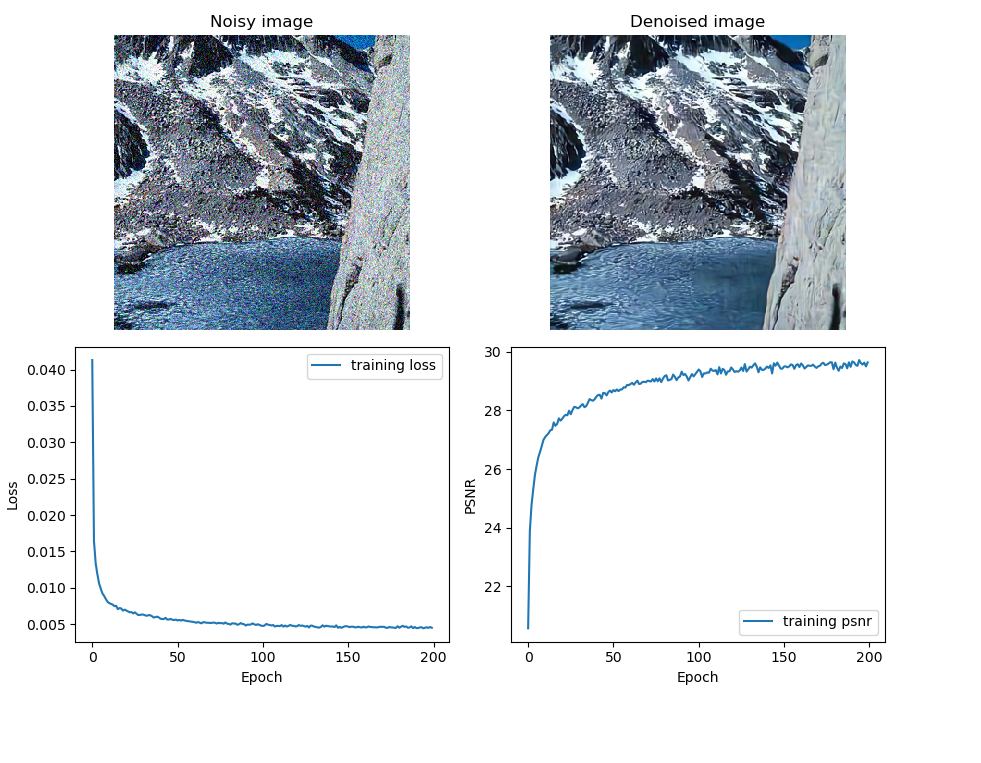

Start/Continue training from epoch 200
Finish training for 200 epochs


In [66]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(9, 7))
exp3.run(num_epochs=200, plot=lambda exp: plot(exp, fig=fig, axes=axes,
                                                noisy=test_set[73][0]))

## Question 19

In [67]:
exp1.evaluate()

{'loss': 0.00524336195550859, 'PSNR': tensor(28.9176, device='cuda:0')}

In [68]:
exp2.evaluate()

{'loss': 0.005854190438985825, 'PSNR': tensor(28.4174, device='cuda:0')}

In [69]:
exp3.evaluate()

{'loss': 0.004930746722966433, 'PSNR': tensor(29.1964, device='cuda:0')}

<IPython.core.display.Javascript object>


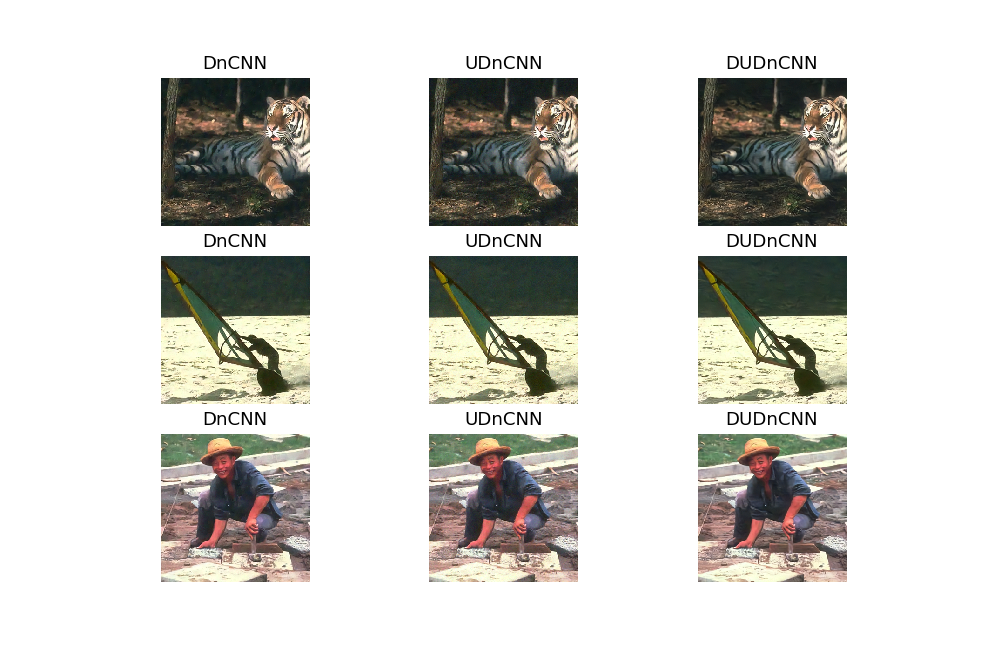

In [72]:
num = 3
img = []
nets = [exp1.net, exp2.net, exp3.net]
titles = ['DnCNN', 'UDnCNN', 'DUDnCNN']

for i in range(num):
    x, _ = test_set[5*i]
    x = x.unsqueeze(0).to(device)
    img.append(x)

fig, axes = plt.subplots(nrows=num, ncols=3, figsize=(9,6), sharex='all', sharey='all')
for i in range(num):
    for j in range(len(nets)):
        model = nets[j].to(device)
        model.eval()
        with torch.no_grad():
            y = model.forward(img[i])

        myimshow(y[0], ax=axes[i][j])
        axes[i][j].set_title(f'{titles[j]}')

## Question 20

In [73]:
for name, param in exp3.net.named_parameters():
    print(name, param.size(), param.requires_grad)

conv.0.weight torch.Size([64, 3, 3, 3]) True
conv.0.bias torch.Size([64]) True
conv.1.weight torch.Size([64, 64, 3, 3]) True
conv.1.bias torch.Size([64]) True
conv.2.weight torch.Size([64, 64, 3, 3]) True
conv.2.bias torch.Size([64]) True
conv.3.weight torch.Size([64, 64, 3, 3]) True
conv.3.bias torch.Size([64]) True
conv.4.weight torch.Size([64, 64, 3, 3]) True
conv.4.bias torch.Size([64]) True
conv.5.weight torch.Size([64, 64, 3, 3]) True
conv.5.bias torch.Size([64]) True
conv.6.weight torch.Size([64, 64, 3, 3]) True
conv.6.bias torch.Size([64]) True
conv.7.weight torch.Size([3, 64, 3, 3]) True
conv.7.bias torch.Size([3]) True
bn.0.weight torch.Size([64]) True
bn.0.bias torch.Size([64]) True
bn.1.weight torch.Size([64]) True
bn.1.bias torch.Size([64]) True
bn.2.weight torch.Size([64]) True
bn.2.bias torch.Size([64]) True
bn.3.weight torch.Size([64]) True
bn.3.bias torch.Size([64]) True
bn.4.weight torch.Size([64]) True
bn.4.bias torch.Size([64]) True
bn.5.weight torch.Size([64]) True

The number of parameters of DUDnCNN is the samebecause dilated convolution does not add more parameters. So, the number of parameters of DUDnCNN(D) is 3456 + 36864 x D

Since the padding size is different, the receptive field for DUDnCNN is $(1+2+\sum_{i=1}^{D/2}2^i\times 2^{i-1}+2^{D/2}\times 2^{D/2-1}+\sum_{i=1}^{D/2-1}2^i\times 2^{i-1}+2)^2$. For DUDnCNN(6), its receptive field is $89^2$. 


    
    

    
    


Hence , seeing the loss, it is clear that DuDnCNN is the best out of the lot.